<a href="https://colab.research.google.com/github/PranitaAnnaldas/A-predictive-model-to-assess-the-environmental-impact-of-urban-expansion/blob/master/ml/Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load temperature data
data = pd.read_csv("temperature_data.csv")

# Convert to datetime and extract components
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%d-%m-%Y %H:%M", errors='coerce')
data = data.dropna(subset=['Datetime'])
data['Date'] = data['Datetime'].dt.date

# Daily average
daily_data = data.groupby('Date').agg(
    maxtempC=('maxtempC', 'mean'),
    mintempC=('mintempC', 'mean')
).reset_index()

# Add date components for seasonality
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data['month'] = daily_data['Date'].dt.month
daily_data['dayofyear'] = daily_data['Date'].dt.dayofyear

# Add lag features (7 days)
for i in range(1, 8):
    daily_data[f'lag_max_{i}'] = daily_data['maxtempC'].shift(i)
    daily_data[f'lag_min_{i}'] = daily_data['mintempC'].shift(i)

# Drop rows with NaN due to shifting
daily_data = daily_data.dropna()

# Define features and targets
features = ['month', 'dayofyear'] + [f'lag_max_{i}' for i in range(1, 8)] + [f'lag_min_{i}' for i in range(1, 8)]
X = daily_data[features]
y_max = daily_data['maxtempC']
y_min = daily_data['mintempC']

# Train-test split
X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.2, random_state=42)
_, _, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.2, random_state=42)

# Train models
rf_max = RandomForestRegressor(random_state=42)
rf_min = RandomForestRegressor(random_state=42)

rf_max.fit(X_train, y_max_train)
rf_min.fit(X_train, y_min_train)

# Evaluate models
print("Max Temp Model MSE:", mean_squared_error(y_max_test, rf_max.predict(X_test)))
print("Min Temp Model MSE:", mean_squared_error(y_min_test, rf_min.predict(X_test)))

# Forecasting for 2031
last_known = daily_data[-7:].copy()
forecast = []
start_date = pd.to_datetime("2031-01-01")
end_date = pd.to_datetime("2031-12-31")
current_date = start_date

while current_date <= end_date:
    month = current_date.month
    dayofyear = current_date.dayofyear

    lags_max = last_known['maxtempC'].values[-7:]
    lags_min = last_known['mintempC'].values[-7:]

    input_row = [month, dayofyear] + list(lags_max) + list(lags_min)
    input_df = pd.DataFrame([input_row], columns=features)

    pred_max = rf_max.predict(input_df)[0]
    pred_min = rf_min.predict(input_df)[0]

    forecast.append({
        'Date': current_date,
        'Predicted_MaxTemp': round(pred_max, 2),
        'Predicted_MinTemp': round(pred_min, 2)
    })

    # Update last_known
    new_row = {
        'Date': current_date,
        'maxtempC': pred_max,
        'mintempC': pred_min
    }
    last_known = pd.concat([last_known, pd.DataFrame([new_row])], ignore_index=True)

    current_date += pd.Timedelta(days=1)

# Save predictions
forecast_df = pd.DataFrame(forecast)
forecast_df.to_csv("temperature_predictions_2031.csv", index=False)

print("✅ Temperature predictions for 2031 saved to 'temperature_predictions_2031.csv'")


Max Temp Model MSE: 1.517382836168031
Min Temp Model MSE: 0.7927212977235768
✅ Temperature predictions for 2031 saved to 'temperature_predictions_2031.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load temperature data
data = pd.read_csv("temperature_data.csv")
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%d-%m-%Y %H:%M", errors='coerce')
data = data.dropna(subset=['Datetime'])
data['Date'] = data['Datetime'].dt.date

# Daily average
daily_data = data.groupby('Date').agg(
    maxtempC=('maxtempC', 'mean'),
    mintempC=('mintempC', 'mean')
).reset_index()

# Add date components for seasonality
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data['month'] = daily_data['Date'].dt.month
daily_data['dayofyear'] = daily_data['Date'].dt.dayofyear

# Add lag features (7 days)
for i in range(1, 8):
    daily_data[f'lag_max_{i}'] = daily_data['maxtempC'].shift(i)
    daily_data[f'lag_min_{i}'] = daily_data['mintempC'].shift(i)

daily_data = daily_data.dropna()

# Define features and targets
features = ['month', 'dayofyear'] + [f'lag_max_{i}' for i in range(1, 8)] + [f'lag_min_{i}' for i in range(1, 8)]
X = daily_data[features]
y_max = daily_data['maxtempC']
y_min = daily_data['mintempC']

# Train-test split
X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.2, random_state=42)
_, _, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.2, random_state=42)

# All models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(verbosity=0),
    'LightGBM': LGBMRegressor(objective='quantile', alpha=0.9, verbose=-1),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR()
}

# Train & evaluate all models
results_max = {}
results_min = {}

for name, model in models.items():
    model_max = model
    model_min = model.__class__(**model.get_params())  # New instance for min

    model_max.fit(X_train, y_max_train)
    model_min.fit(X_train, y_min_train)

    mse_max = mean_squared_error(y_max_test, model_max.predict(X_test))
    mse_min = mean_squared_error(y_min_test, model_min.predict(X_test))

    results_max[name] = (mse_max, model_max)
    results_min[name] = (mse_min, model_min)

# Pick best models
best_model_max_name = min(results_max, key=lambda x: results_max[x][0])
best_model_min_name = min(results_min, key=lambda x: results_min[x][0])
best_model_max = results_max[best_model_max_name][1]
best_model_min = results_min[best_model_min_name][1]

print(f"✅ Best model for Max Temp: {best_model_max_name} (MSE: {results_max[best_model_max_name][0]:.4f})")
print(f"✅ Best model for Min Temp: {best_model_min_name} (MSE: {results_min[best_model_min_name][0]:.4f})")

# Forecasting for 2031
last_known = daily_data[-7:].copy()
forecast = []
start_date = pd.to_datetime("2031-01-01")
end_date = pd.to_datetime("2031-12-31")
current_date = start_date

while current_date <= end_date:
    month = current_date.month
    dayofyear = current_date.dayofyear

    lags_max = last_known['maxtempC'].values[-7:]
    lags_min = last_known['mintempC'].values[-7:]

    input_row = [month, dayofyear] + list(lags_max) + list(lags_min)
    input_df = pd.DataFrame([input_row], columns=features)

    pred_max = best_model_max.predict(input_df)[0]
    pred_min = best_model_min.predict(input_df)[0]

    forecast.append({
        'Date': current_date,
        'Predicted_MaxTemp': round(pred_max, 2),
        'Predicted_MinTemp': round(pred_min, 2)
    })

    last_known = pd.concat([last_known, pd.DataFrame([{
        'Date': current_date,
        'maxtempC': pred_max,
        'mintempC': pred_min
    }])], ignore_index=True)

    current_date += pd.Timedelta(days=1)

# Save predictions
forecast_df = pd.DataFrame(forecast)
forecast_df.to_csv("temperature_predictions_2031.csv", index=False)

print("📁 Saved predictions to 'temperature_predictions_2031.csv'")


✅ Best model for Max Temp: Gradient Boosting (MSE: 1.3709)
✅ Best model for Min Temp: Linear Regression (MSE: 0.7575)
📁 Saved predictions to 'temperature_predictions_2031.csv'


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


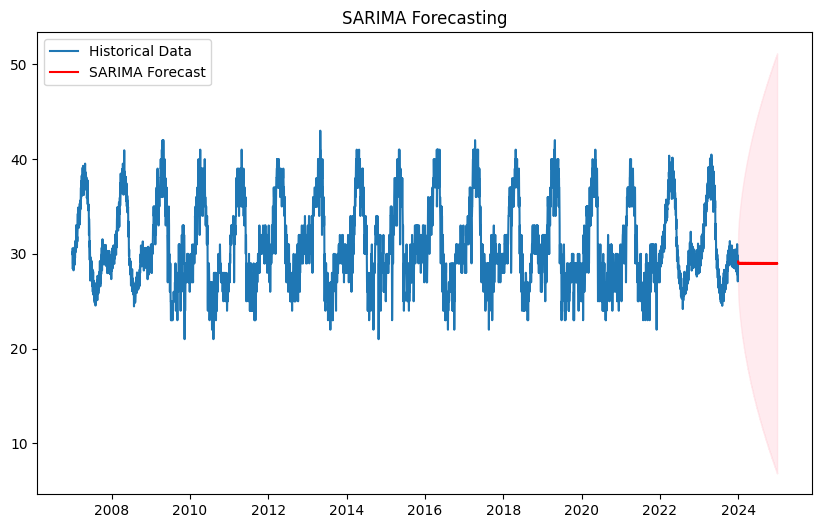

SARIMA MSE: 19.347877637755857


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('temperature_data.csv')  # Replace with your data path
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Aggregate the data to daily
data['Date'] = data['Datetime'].dt.date
daily_data = data.groupby('Date').agg({'maxtempC': 'mean', 'mintempC': 'mean'}).reset_index()

# Set the 'Date' column as index
daily_data.set_index('Date', inplace=True)

# Training the SARIMA model (you can tune the order)
sarima_model = SARIMAX(daily_data['maxtempC'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Seasonal order (p,d,q,s)
sarima_fit = sarima_model.fit(disp=False)

# Predicting the future (for example, predicting the next 365 days)
forecast_sarima = sarima_fit.get_forecast(steps=365)
forecast_sarima_ci = forecast_sarima.conf_int()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data['maxtempC'], label='Historical Data')
plt.plot(forecast_sarima.predicted_mean.index, forecast_sarima.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(forecast_sarima_ci.index, forecast_sarima_ci.iloc[:, 0], forecast_sarima_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecasting')
plt.show()

# Evaluate the model
y_true = daily_data['maxtempC'][-365:]  # Replace with actual test data if available
y_pred = forecast_sarima.predicted_mean
mse_sarima = mean_squared_error(y_true, y_pred)
print(f'SARIMA MSE: {mse_sarima}')


In [ ]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.1 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached httpstan-4.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pysimdjson-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl.metadata (748 bytes)
  Using cached pastel-0.2.1-py2.py3-none-any.whl.metadata (1.9 kB)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n9n1ra4/pw2bk05j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n9n1ra4/y9dhbw_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8122', 'data', 'file=/tmp/tmp_n9n1ra4/pw2bk05j.json', 'init=/tmp/tmp_n9n1ra4/y9dhbw_k.json', 'output', 'file=/tmp/tmp_n9n1ra4/prophet_model7a0nrctr/prophet_model-20250415054632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:46:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE) for the model: 3.005021703376008


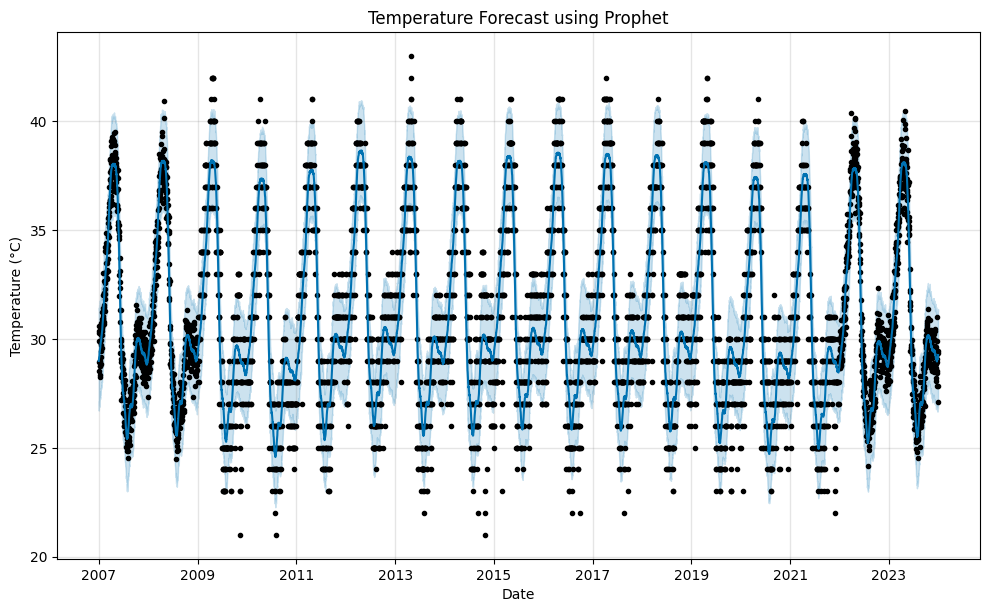

             ds       yhat  yhat_lower  yhat_upper
6204 2023-12-27  29.064517   26.658305   31.136441
6205 2023-12-28  29.072805   26.880144   31.341980
6206 2023-12-29  29.096740   26.859260   31.373934
6207 2023-12-30  29.119793   26.809386   31.259270
6208 2023-12-31  29.259149   26.977944   31.371682


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load and prepare the dataset
data = pd.read_csv('temperature_data.csv')  # Replace with your data path

# Ensure 'Datetime' column is in datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Aggregate the data to daily level (if required, depends on your dataset)
data['Date'] = data['Datetime'].dt.date
daily_data = data.groupby('Date')['maxtempC'].mean().reset_index()

# Step 2: Prepare the data for Prophet
# Prophet requires a 'ds' column (for dates) and a 'y' column (for the values to predict)
prophet_data = daily_data.rename(columns={'Date': 'ds', 'maxtempC': 'y'})  # Rename columns for Prophet

# Step 3: Initialize the Prophet model
prophet_model = Prophet()

# Step 4: Fit the model
prophet_model.fit(prophet_data)

# Step 5: Make predictions on historical data to calculate MSE
forecast = prophet_model.predict(prophet_data)

# Step 6: Calculate MSE for the historical data
mse = mean_squared_error(prophet_data['y'], forecast['yhat'])
print(f"Mean Squared Error (MSE) for the model: {mse}")

# Step 7: Plot the results
prophet_model.plot(forecast)
plt.title('Temperature Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

# Optionally, display the forecasted values (including uncertainty intervals)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0301
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0071
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0067
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0059
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0056
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0049
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0047
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0044
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0041
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0038
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
LSTM MSE: 923.6203439796783


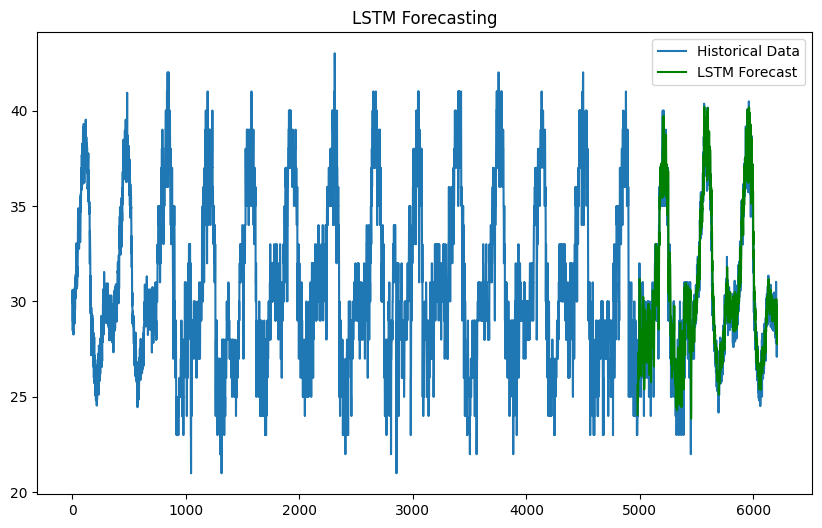

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(daily_data[['maxtempC']])

# Create sequences for LSTM (X, y)
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Time steps for LSTM input
X, y = create_sequences(data_scaled, time_step)

# Reshape X for LSTM (samples, time_steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64)

# Predict using the LSTM model
predictions_lstm = model.predict(X_test)

# Inverse transform the predictions
predictions_lstm_rescaled = scaler.inverse_transform(predictions_lstm)

# Evaluate the model
mse_lstm = mean_squared_error(y_test, predictions_lstm_rescaled)
print(f'LSTM MSE: {mse_lstm}')

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(daily_data['maxtempC'])), daily_data['maxtempC'], label='Historical Data')
plt.plot(np.arange(len(daily_data['maxtempC'])-len(predictions_lstm_rescaled), len(daily_data['maxtempC'])), predictions_lstm_rescaled, label='LSTM Forecast', color='green')
plt.legend()
plt.title('LSTM Forecasting')
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n9n1ra4/k06o6m4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n9n1ra4/7ixkoppo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42179', 'data', 'file=/tmp/tmp_n9n1ra4/k06o6m4g.json', 'init=/tmp/tmp_n9n1ra4/7ixkoppo.json', 'output', 'file=/tmp/tmp_n9n1ra4/prophet_modeljlvsxd8f/prophet_model-20250415055650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:56:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:56:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE) for the model: 3.005021703376008


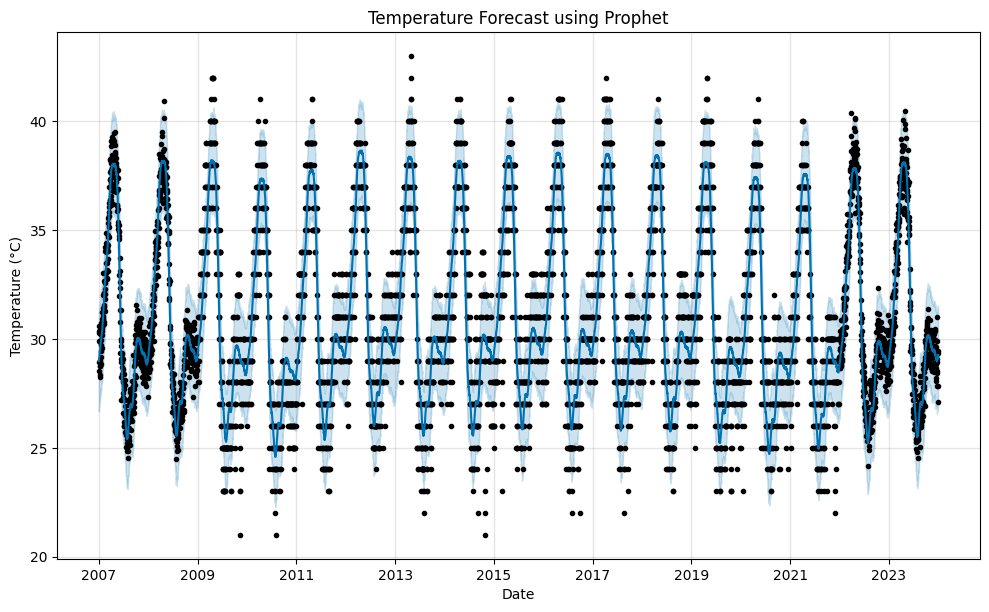

             ds       yhat  yhat_lower  yhat_upper
6204 2023-12-27  29.064517   26.820711   31.195285
6205 2023-12-28  29.072805   26.884285   31.405980
6206 2023-12-29  29.096740   26.680277   31.483525
6207 2023-12-30  29.119793   27.076112   31.265550
6208 2023-12-31  29.259149   26.979952   31.524983
             ds       yhat   min_temp   max_temp
2918 2031-12-27  31.130699  22.284788  40.365759
2919 2031-12-28  31.254552  22.353695  40.138318
2920 2031-12-29  31.240923  22.142216  40.313543
2921 2031-12-30  31.315375  21.997128  40.902671
2922 2031-12-31  31.327954  22.482045  40.444136


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load and prepare the dataset
data = pd.read_csv('temperature_data.csv')

# Ensure 'Datetime' column is in datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Aggregate the data to daily level (if required, depends on your dataset)
data['Date'] = data['Datetime'].dt.date
daily_data = data.groupby('Date')['maxtempC'].mean().reset_index()

# Step 2: Prepare the data for Prophet
# Prophet requires a 'ds' column (for dates) and a 'y' column (for the values to predict)
prophet_data = daily_data.rename(columns={'Date': 'ds', 'maxtempC': 'y'})

# Step 3: Initialize the Prophet model
prophet_model = Prophet()

# Step 4: Fit the model
prophet_model.fit(prophet_data)

# Step 5: Make predictions on historical data to calculate MSE
forecast = prophet_model.predict(prophet_data)

# Step 6: Calculate MSE for the historical data
mse = mean_squared_error(prophet_data['y'], forecast['yhat'])
print(f"Mean Squared Error (MSE) for the model: {mse}")

# Step 7: Plot the results
prophet_model.plot(forecast)
plt.title('Temperature Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

# Optionally, display the forecasted values (including uncertainty intervals)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Step 8: Generate future dates manually until the year 2031
# Generate a list of dates from the end of the dataset to the end of 2031
last_date = pd.to_datetime(daily_data['Date'].max())
future_dates = pd.date_range(last_date, '2031-12-31', freq='D')

# Step 9: Create a dataframe with these future dates
future_df = pd.DataFrame(future_dates, columns=['ds'])

# Step 10: Make predictions for the future
forecast_future = prophet_model.predict(future_df)

# Step 11: Store the results in a CSV file
forecast_future['min_temp'] = forecast_future['yhat_lower']  # Min temp (lower bound of forecast)
forecast_future['max_temp'] = forecast_future['yhat_upper']  # Max temp (upper bound of forecast)

# Select relevant columns for the final output
output = forecast_future[['ds', 'yhat', 'min_temp', 'max_temp']]

# Save the results to a CSV file
output.to_csv('temperature_forecast_2031.csv', index=False)

# Display the last few rows of the forecast
print(output.tail())
